### EFFICIENTNET

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import glob
path ="/content/drive/MyDrive/TA STECHOQ/brain tumor/Testing"

In [ ]:
filename=glob.glob(path+"/*/*.jpg")

In [ ]:
import cv2 as cv
img = cv.imread(filename[0])
img.shape

(512, 512, 3)

In [ ]:
import os
import numpy as np
def read_data(filename):
  labels=[]
  images=[]
  for i in filename:
    label=os.path.dirname(i)
    labels.append(os.path.basename(label))
    img=cv.imread(i)
    img=cv.resize(img,(200,200))
    images.append(img)
  images=np.asarray(images)
  return(images,labels)


In [ ]:
images, labels=read_data(filename)

In [ ]:
images.shape

(394, 200, 200, 3)

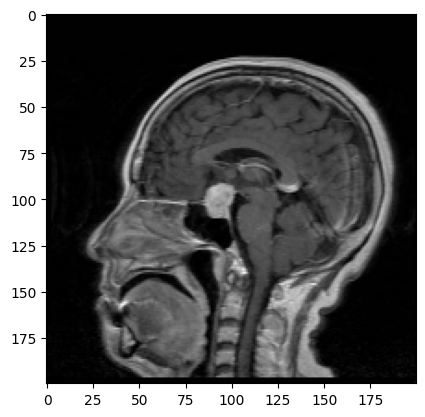

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[2], cmap='bone')

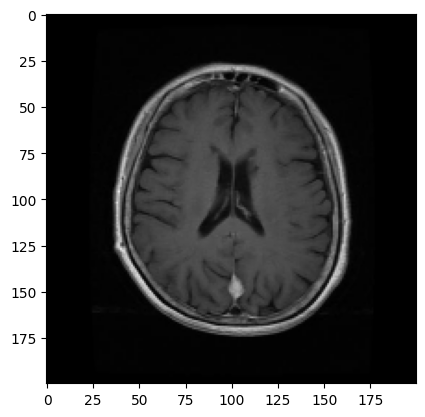

In [ ]:
images_rgb=[]
for i in range (images.shape[0]):
  im_rgb=cv.cvtColor(images[i],cv.COLOR_BGR2RGB)
  images_rgb.append(im_rgb)

images_rgb=np.asarray(images_rgb)
plt.imshow(images_rgb[0],cmap="bone")

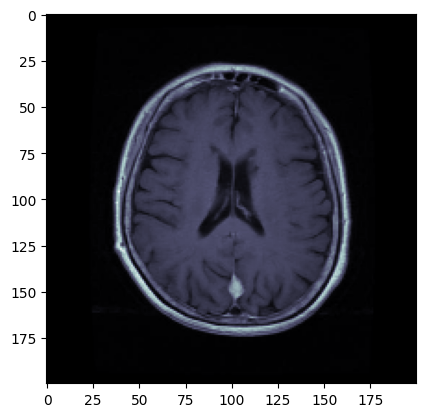

In [ ]:
green_channel = images_rgb[:,:,:,1]
green_channel = np.asarray(green_channel)
plt.imshow(green_channel[0],cmap="bone")

In [ ]:
images.shape[0]==len(labels)

True

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
lb.fit(labels)
y = lb.transform(labels)

In [ ]:
y.shape

(394,)

In [ ]:
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
enc.fit(np.expand_dims(y,-1))
yoh= enc.transform(np.expand_dims(y,-1)).toarray()

In [ ]:
yoh.shape

(394, 4)

In [ ]:
images = green_channel.astype(np.float32)

In [ ]:
images = np.expand_dims(images,-1)

In [ ]:
images.shape[1:4]

(200, 200, 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images,yoh, test_size = 0.3 , random_state = 42)

In [ ]:
from tensorflow.keras import Sequential

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model_efficientnetb3 = EfficientNetB3( include_top=False,
    weights="imagenet",
    input_shape=(200,200,3),
    pooling='max',
    classifier_activation="softmax",)

for layer in model_efficientnetb3.layers:
    layer.trainable = False

model=Sequential([
    model_efficientnetb3,
    BatchNormalization(axis=-1, momentum=0.016),
    Dense(512,kernel_regularizer=regularizers.l2(l= 0.016), activation='relu'),
    Dropout(0.2),
    Dense(64,kernel_regularizer=regularizers.l2(l= 0.016), activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 512)               786944    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [ ]:
model.compile(optimizer ="adam", loss="categorical_crossentropy",
              metrics =["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
ms = ModelCheckpoint("/content/drive/MyDrive/TA STECHOQ/brain tumor/bobot.h5",
                     monitor='val_loss', verbose=1, save_best_only=True, save_weight_only=True,
                     mode='auto', save_freq='epoch')

In [ ]:
loss_history =  model.fit(x_train, y_train, epochs=20,
                          batch_size=4, verbose=1,
                          validation_split=0.3, shuffle=True,
                          callbacks=[ms])

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 6.4102 - accuracy: 0.7552
Epoch 1: val_loss improved from 8.20445 to 7.29144, saving model to /content/drive/MyDrive/TA STECHOQ/brain tumor/bobot.h5
48/48 [==============================] - 40s 840ms/step - loss: 6.4102 - accuracy: 0.7552 - val_loss: 7.2914 - val_accuracy: 0.5663
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 5.3435 - accuracy: 0.8438
Epoch 2: val_loss improved from 7.29144 to 6.53173, saving model to /content/drive/MyDrive/TA STECHOQ/brain tumor/bobot.h5
48/48 [==============================] - 37s 774ms/step - loss: 5.3435 - accuracy: 0.8438 - val_loss: 6.5317 - val_accuracy: 0.6265
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 4.6987 - accuracy: 0.7708
Epoch 3: val_loss improved from 6.53173 to 6.21413, saving model to /content/drive/MyDrive/TA STECHOQ/brain tumor/bobot.h5
48/48 [==============================] - 32s 682ms/step - loss: 4.6987 - accuracy: 0.

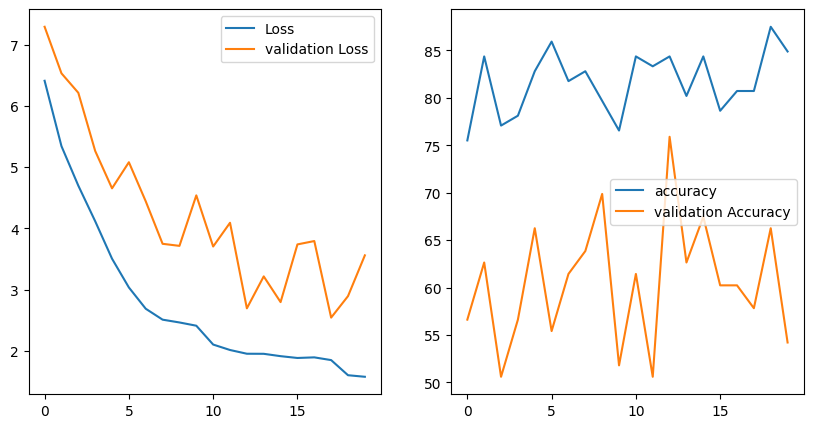

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.plot(loss_history.history['loss'],'-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'],'-',label='validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['accuracy']),'-',label='accuracy')
ax2.plot(100*np.array(loss_history.history['val_accuracy']),'-',label = 'validation Accuracy')
ax2.legend()

In [ ]:
model.load_weights("/content/drive/MyDrive/TA STECHOQ/brain tumor/bobot.h5")

In [ ]:
pred=model.predict(x_test)

4/4 [==============================] - 22s 4s/step


In [ ]:
pred=np.argmax(pred,axis=1)

In [ ]:
y_test=np.argmax(y_test,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred)

array([[15,  5,  1,  1],
       [14, 23,  3,  0],
       [ 7,  5, 19,  0],
       [ 2,  5,  0, 19]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred,target_names=lb.classes_))

                  precision    recall  f1-score   support

    glioma_tumor       0.39      0.68      0.50        22
meningioma_tumor       0.61      0.57      0.59        40
        no_tumor       0.83      0.61      0.70        31
 pituitary_tumor       0.95      0.73      0.83        26

        accuracy                           0.64       119
       macro avg       0.69      0.65      0.65       119
    weighted avg       0.70      0.64      0.65       119

